# Stock Predictor RNN 

Predicción de las acciones de Apple

## Carga de datos

Primero carguemos nuestra serie temporal: un historial de alrededor de 140 días del precio de las acciones de Apple. Luego, debemos realizar una serie de pasos de preprocesamiento para prepararlo para su uso con un modelo RNN. En primer lugar, es una buena práctica normalizar las series de tiempo, normalizando su rango. Esto nos ayuda a evitar problemas numéricos graves asociados con la forma en que las funciones de activación comunes (como tanh) transforman números muy grandes (positivos o negativos), además de ayudarnos a evitar problemas relacionados al calcular derivadas. 

Datos normalizados [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

dataset = np.loadtxt('data/normalized_apple_prices.csv')

Visualizacion de los datos

Text(0, 0.5, 'serie normalizada')

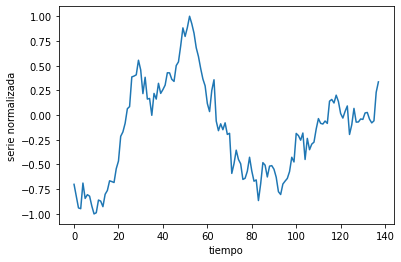

In [2]:
plt.plot(dataset)
plt.xlabel('tiempo')
plt.ylabel('serie normalizada')

## Paso 2:  Cortando las series en secuencias
Recuerde, nuestra serie de tiempo es una secuencia de números que podemos representar matemáticamente en general como 
$$s_{0},s_{1},s_{2},...,s_{P}$$

donde $ s_ {p} $ es el valor numérico de la serie de tiempo en el período de tiempo $ p $ y donde $ P $ es la longitud total de la serie. Para aplicar nuestro RNN, tratamos el problema de predicción de series de tiempo como un problema de regresión, por lo que necesitamos usar una ventana deslizante para construir un conjunto de pares de entrada / salida asociados para retroceder. Este proceso está animado en el gif a continuación. 

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

Por ejemplo, utilizando una ventana de tamaño T = 5 (como se ilustra en el gif anterior) producimos un conjunto de pares de entrada / salida como el que se muestra en la tabla a continuación. 

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Observe aquí que cada entrada es una secuencia (o vector) de longitud 4 (y en general tiene una longitud igual al tamaño de ventana T) mientras que cada salida correspondiente es un valor escalar. Observe también cómo, dada una serie de tiempo de longitud P y tamaño de ventana T = 5 como se muestra arriba, creamos P - 5 pares de entrada / salida. De manera más general, para un tamaño de ventana T creamos P - T tales pares.

¡Ahora veamos la serie de tiempo de entrada como se describe arriba! 

In [3]:
### The function below transforms the input series and window-size into a set of input/output pairs for our RNN model
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    for i in range(window_size, len(series)):
        X.append(series[i - window_size:i])
        y.append(series[i])
        
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

In [4]:
# And now we can window the data using our windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

## Paso 3: Separar Train y Test

Para realizar las pruebas adecuadas en nuestro conjunto de datos, cortaremos el último 1/3 para su validación (o prueba).

Tenga en cuenta que aquí ** no ** dividimos el conjunto de datos * aleatoriamente * como se haría normalmente al validar un modelo de regresión. Esto se debe a que nuestros pares de entrada / salida * están relacionados temporalmente *. No queremos validar nuestro modelo entrenando en un subconjunto aleatorio de la serie y luego probando en otro subconjunto aleatorio, ya que esto simula el escenario en el que recibimos nuevos puntos * dentro del marco de tiempo de nuestro conjunto de entrenamiento *.

Queremos entrenar en una parte sólida de la serie (en nuestro caso, los primeros 2/3 completos) y validar en una parte posterior (el último 1/3), ya que esto simula cómo predeciríamos los valores * futuros *. de una serie de tiempo. 

In [5]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## Step 4:  Construir y entrenar una RNN


Después de haber creado pares de entrada / salida a partir de nuestra serie de tiempo y cortar esto en conjuntos de entrenamiento / prueba, ahora podemos comenzar a configurar nuestro RNN. Usamos Keras para construir rápidamente un RNN de dos capas ocultas de las siguientes especificaciones 

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [9]:
# import keras network libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


# start with fixed random seed
np.random.seed(0)


# Build an RNN to perform regression on our time series input/output data
model = Sequential()
model.add(LSTM(5, input_shape=(window_size, 1)))
model.add(Dense(1))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Ahora podemos entrenar el modelo

In [10]:
model.fit(X_train, y_train, epochs=500, batch_size=64, verbose=1)

Epoch 1/500
2/2 [==============================] - 10s 26ms/step - loss: 0.1412
Epoch 2/500
2/2 [==============================] - 0s 14ms/step - loss: 0.1229
Epoch 3/500
2/2 [==============================] - 0s 13ms/step - loss: 0.1210
Epoch 4/500
2/2 [==============================] - 0s 36ms/step - loss: 0.1147
Epoch 5/500
2/2 [==============================] - 0s 13ms/step - loss: 0.1135
Epoch 6/500
2/2 [==============================] - 0s 14ms/step - loss: 0.1081
Epoch 7/500
2/2 [==============================] - 0s 13ms/step - loss: 0.1084
Epoch 8/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0992
Epoch 9/500
2/2 [==============================] - 0s 11ms/step - loss: 0.1013
Epoch 10/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0921
Epoch 11/500
2/2 [==============================] - 0s 17ms/step - loss: 0.0970
Epoch 12/500
2/2 [==============================] - 0s 19ms/step - loss: 0.0926
Epoch 13/500
2/2 [==============================

## Paso 5: Verificando el modelo


With our model fit we can now make predictions on both our training and testing sets.

In [11]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [12]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.016358334571123123
testing error = 0.014403694309294224


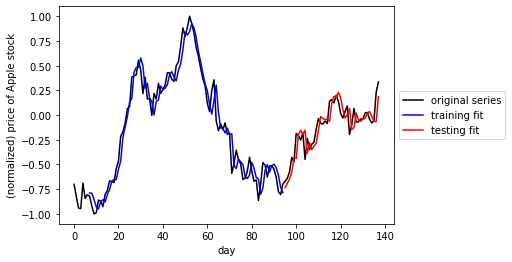

In [13]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()